In [1]:
import pandas as pd
movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape



(50000, 2)

In [2]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

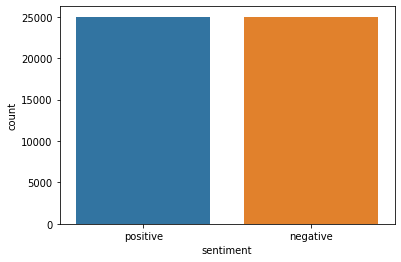

In [4]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Activation,Conv1D,MaxPooling1D,Flatten,Conv2D

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error


In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dark1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('br')
stemmer=nltk.stem.WordNetLemmatizer()
def text_prepare(text):

    remove_tags(text)  
    # text = re.sub('[^a-zA-Z]', ' ', text)# Remove punctuations and numbers
    # text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)# Single character removal
    # text = re.sub(r'\s+', ' ', text)# Removing multiple spaces
    text = text.lower()# lowercase text  
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = re.sub(BAD_SYMBOLS_RE,' ',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    text = ' '.join(s for s in text.split() if s not in STOPWORDS)# delete stopwords from text  
    text = ' '.join(stemmer.lemmatize(token) for token in text.split())
    return text

In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(text_prepare(sen))

In [10]:
X[3]

'basically family little boy jake think zombie closet parent fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parent divorcing arguing like real life jake closet totally ruin film expected see boogeyman similar movie instead watched drama meaningless thriller spot 3 10 well playing parent descent dialog shot jake ignore'

In [11]:
import numpy as np

Y=movie_reviews['sentiment']
Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [12]:
Y[3]


0

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
#print(X_train[6])

In [14]:
from collections import defaultdict

words_counts = defaultdict(int)
for text in X:  #X_train
    for word in text.split():
        words_counts[word] += 1

In [15]:
print(len(words_counts))

92000


In [16]:
DICT_SIZE = 46000  
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])}
def my_bag_of_words(text, words_to_index, dict_size):

    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector


In [17]:
print(len(most_common_words))

46000


In [18]:
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])


X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])


In [19]:
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (40000, 46000)
X_test shape  (10000, 46000)


In [20]:
print(X_test_mybag [4].shape)

(1, 46000)


In [21]:
X_test_mybag.shape[1]

46000

In [22]:
print(X_train[1])

watch entire movie could watch entire movie stopped dvd watching half hour suggest anyone thinking watching stop taking disc case like mafia movie tragic comic corky romano described tragic attempt mafia comedy problem corky romano simply try hard get audience laugh plot seems excuse moving chris kattan corky one scene another corky completely overplayed lack subtlety credulity strange mannerism come across contrived chris kattan clearly acting rather taking role bounce right story scene utterly predictable comedic event occur set obvious soon scene introduced comedy mr bean disaster caused title character funny empathise character motivation initial event situation character end telegraphed corky however give feeling deliberately screwing desperate attempt draw laugh audience chris played alien character never really connects character movie whose behaviour entirely inexplicable except trying draw laugh comedy scene predictable stereotyped joke seemed far familiar movie could watchabl

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
def tfidf_features(X_train, X_test):
    
    tfidf_vectorizer = TfidfVectorizer(min_df = 5 ,max_df = 0.8 ,ngram_range=(1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)   
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train,X_test, tfidf_vectorizer.vocabulary_

In [25]:
X_train_tfidf,X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [26]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)

In [27]:
print(X_train[3]) 

latter day fulci schlocker totally abysmal concoction dealing incurable gambler brett halsey decides bluebeard style pay ever rising debt seducing ugliest bitch ever lay eye happen wealthy widow fulci penned script also contrives incorporate blackly comedic element result unfunny business involving corpse stay put opera singer victim stop singing etc mention doppelganger theme straight student prague although case two persona communicate via pre recorded radio message end say surprised film show sign sophistication mario bava hatchet honeymoon 1970 resembles several way content merely pile disgustingly gory none convincing effect dismembered limb squashed melting face ala fulci become completely associated


In [28]:
print(X_test_tk[3])

[992, 3354, 10, 300, 3, 1019, 175, 4165, 1449, 3102, 70, 111, 538, 147, 4047, 141, 955, 573, 765, 573, 176, 45, 1396, 3835, 21, 216, 906, 427, 704, 155, 21, 400, 3262, 4193, 854, 3102, 4193, 460, 275, 3756, 66, 663, 1078, 23, 1468, 854, 9, 104, 425, 999]


In [29]:
maxlen=70
X_train_tk = pad_sequences(X_train_tk, padding='post', maxlen=maxlen)
X_test_tk = pad_sequences(X_test_tk, padding='post', maxlen=maxlen)

In [30]:
print(X_train_tk[3])

[4055 1633  953  272  731   47 3880 4789 4887   47 2950  223  454 2649
 3679 2461  119   21 1538  436  574 1833  817 1053 3146  520  141 1115
 1326  657  374 1022  395  577  411  593  645  166  277   36 3006 2481
 1620 3550 1282  539   40   41  643    2   23 1329 3397 2469 3478  331
   24 1250 1443 2192 1883  506  955  128  225 2209 2461  328  239 3219]


In [31]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [32]:
len(embeddings_dictionary)

400000

In [33]:
vocab_size=len(words_counts)

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [34]:
print(embedding_matrix.shape)

(92000, 100)


In [114]:
#machine learning

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
model = LogisticRegression()
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)



C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [117]:
from sklearn import metrics

In [118]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[4349,  612],
       [ 541, 4498]], dtype=int64)

In [119]:
from sklearn.metrics import accuracy_score

In [120]:
accuracy_score(Y_test, Y_pred_mybag)

0.8847

In [121]:
model = LogisticRegression()
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [122]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[4386,  575],
       [ 437, 4602]], dtype=int64)

In [123]:
accuracy_score(Y_test, Y_pred_tfidf)

0.8988

In [124]:
model = LogisticRegression()
model.fit(X_train_tk,Y_train)

Y_pred_mybag=model.predict(X_test_tk)



In [125]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[2794, 2167],
       [2526, 2513]], dtype=int64)

In [126]:
from sklearn.metrics import accuracy_score

In [127]:
accuracy_score(Y_test, Y_pred_mybag)

0.5307

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
model = RandomForestClassifier(600)
model.fit(X_train_mybag,Y_train)
Y_pred_rf=model.predict(X_test_mybag)

model.score(X_test_mybag,Y_test)

0.876

In [56]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_rf)
print(cnf_matrix)

[[4304  657]
 [ 583 4456]]


In [57]:
accuracy_score(Y_test, Y_pred_rf)

0.876

In [58]:
model = RandomForestClassifier(600)
model.fit(X_train_tfidf,Y_train)
Y_pred_tfidf=model.predict(X_test_tfidf)

model.score(X_test_tfidf,Y_test)

0.8736

In [59]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[4308,  653],
       [ 611, 4428]], dtype=int64)

In [60]:
accuracy_score(Y_test, Y_pred_tfidf)

0.8736

In [61]:
model = RandomForestClassifier(600)
model.fit(X_train_tk,Y_train)
Y_pred_rf=model.predict(X_test_tk)

model.score(X_test_tk,Y_test)

0.5582

In [62]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_rf)
print(cnf_matrix)

[[2881 2080]
 [2338 2701]]


In [63]:
accuracy_score(Y_test, Y_pred_rf)

0.5582

In [64]:
from sklearn.svm import SVC

In [65]:
model = SVC(C=600)
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [66]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[4384,  577],
       [ 481, 4558]], dtype=int64)

In [67]:
accuracy_score(Y_test, Y_pred_mybag)

0.8942

In [68]:

model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [69]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[3504, 1457],
       [ 428, 4611]], dtype=int64)

In [70]:
accuracy_score(Y_test, Y_pred_tfidf)

0.8115

In [71]:
model = SVC(C=600)
model.fit(X_train_tk,Y_train)

Y_pred_tk=model.predict(X_test_tk)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [72]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tk)
cnf_matrix

array([[ 108, 4853],
       [   0, 5039]], dtype=int64)

In [73]:
accuracy_score(Y_test, Y_pred_tk)

0.5147

In [74]:
from sklearn import tree

In [75]:
model= tree.DecisionTreeClassifier()

In [76]:
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


In [77]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[3611, 1350],
       [1382, 3657]], dtype=int64)

In [78]:
accuracy_score(Y_test, Y_pred_mybag)

0.7268

In [79]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [80]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[3654, 1307],
       [1403, 3636]], dtype=int64)

In [81]:
accuracy_score(Y_test, Y_pred_tfidf)

0.729

In [82]:
model.fit(X_train_tk,Y_train)

Y_pred_tk=model.predict(X_test_tk)


In [83]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tk)
cnf_matrix

array([[2629, 2332],
       [2353, 2686]], dtype=int64)

In [84]:
accuracy_score(Y_test, Y_pred_tk)

0.5315

In [106]:
from keras import metrics
from sklearn.metrics import recall_score  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
import matplotlib. pyplot as plt

In [47]:
#word embedding

In [48]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())

model.add(Dense(128, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 100)           9200000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 7000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               896128    
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 34        
_________________________________________________________________
dropout_4 (Dropout)          (None, 2)                

In [49]:
history = model.fit(X_train_tk, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 9s 268us/step - loss: 0.6660 - acc: 0.6172 - recall_2: 0.6921 - precision_2: 0.6009 - val_loss: 0.6287 - val_acc: 0.7483 - val_recall_2: 0.7607 - val_precision_2: 0.7422
Epoch 2/6
32000/32000 [==============================] - 9s 272us/step - loss: 0.6021 - acc: 0.7168 - recall_2: 0.6300 - precision_2: 0.7610 - val_loss: 0.5942 - val_acc: 0.7327 - val_recall_2: 0.8558 - val_precision_2: 0.6868
Epoch 3/6
32000/32000 [==============================] - 9s 277us/step - loss: 0.5596 - acc: 0.7332 - recall_2: 0.6387 - precision_2: 0.7863 - val_loss: 0.5585 - val_acc: 0.7571 - val_recall_2: 0.7615 - val_precision_2: 0.7549
Epoch 4/6
32000/32000 [==============================] - 9s 293us/step - loss: 0.5297 - acc: 0.7468 - recall_2: 0.6544 - precision_2: 0.8015 - val_loss: 0.5447 - val_acc: 0.7556 - val_recall_2: 0.7993 - val_precision_2: 0.7351
Epoch 5/6
32000/32000 [====================

In [50]:
pr = model.predict(X_test_tk)

In [51]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y_test, pr.round())
cnf_matrix

array([[3374, 1587],
       [ 937, 4102]], dtype=int64)

In [52]:
recall_score(Y_test, pr.round())

0.8140504068267513

In [53]:
mean_squared_error(Y_test, pr.round())

0.2524

In [54]:
precision_score(Y_test, pr.round())

0.72104060467569

In [55]:
accuracy_score(Y_test, pr.round())

0.7476

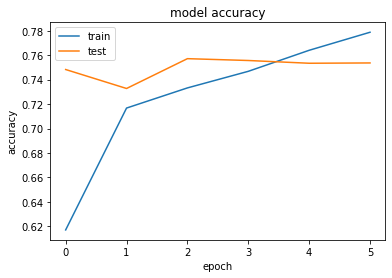

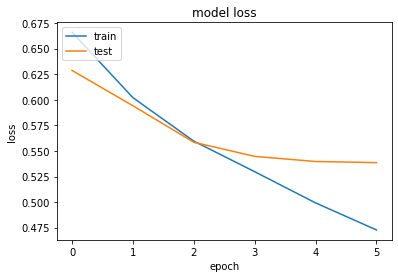

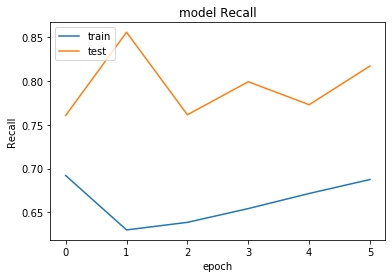

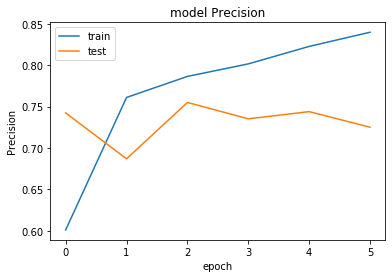

In [56]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_2'])
plt.plot(history.history['val_precision_2'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [36]:
#CNN

In [66]:

from keras.layers import Activation,Conv1D,MaxPooling2D,Flatten
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128,5, activation='sigmoid'))
model.add(Conv1D(16,5, activation='sigmoid'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Conv1D(2,5, activation='sigmoid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 100)           9200000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 66, 128)           64128     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 62, 16)            10256     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 31, 16)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 16)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 27, 2)             162       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 2)                

In [67]:
history = model.fit(X_train_tk, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 34s 1ms/step - loss: 0.6954 - acc: 0.5003 - recall_3: 0.2381 - precision_3: 0.4980 - val_loss: 0.6932 - val_acc: 0.5000 - val_recall_3: 1.0000 - val_precision_3: 0.5000
Epoch 2/6
32000/32000 [==============================] - 41s 1ms/step - loss: 0.6748 - acc: 0.5709 - recall_3: 0.3806 - precision_3: 0.6124 - val_loss: 0.6207 - val_acc: 0.7045 - val_recall_3: 0.5515 - val_precision_3: 0.7947
Epoch 3/6
32000/32000 [==============================] - 45s 1ms/step - loss: 0.6096 - acc: 0.7114 - recall_3: 0.7602 - precision_3: 0.6917 - val_loss: 0.5904 - val_acc: 0.7234 - val_recall_3: 0.8410 - val_precision_3: 0.6808
Epoch 4/6
32000/32000 [==============================] - 40s 1ms/step - loss: 0.5885 - acc: 0.7222 - recall_3: 0.8005 - precision_3: 0.6913 - val_loss: 0.5661 - val_acc: 0.7395 - val_recall_3: 0.7782 - val_precision_3: 0.7223
Epoch 5/6
32000/32000 [========================

In [68]:
pr = model.predict(X_test_tk)

In [72]:
cnf_matrix = metrics.confusion_matrix(Y_test, pr.round())
cnf_matrix

array([[3140, 1821],
       [ 770, 4269]], dtype=int64)

In [73]:
recall_score(Y_test, pr.round())

0.847191903155388

In [74]:
mean_squared_error(Y_test, pr.round())

0.2591

In [75]:
precision_score(Y_test, pr.round())

0.7009852216748769

In [70]:
accuracy_score(Y_test, pr.round())

0.7409

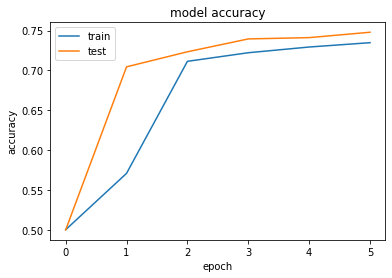

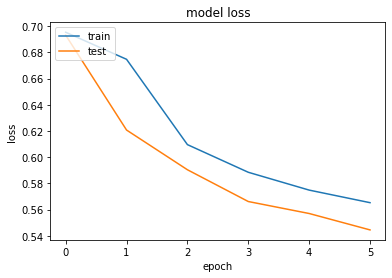

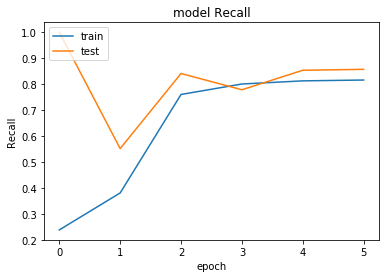

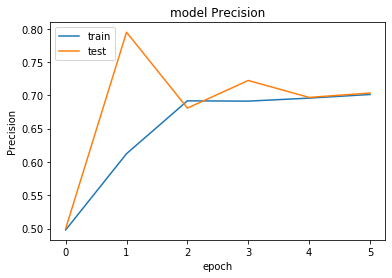

In [76]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_3'])
plt.plot(history.history['val_recall_3'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_3'])
plt.plot(history.history['val_precision_3'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [22]:
#LSTM

In [49]:

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(128,return_sequences = True))
model.add(LSTM(16,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(2,return_sequences = False))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',metrics.Recall(),metrics.Precision()])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 100)           9200000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 128)           117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 16)            9280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 2)                 152       
_________________________________________________________________
dropout_4 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [50]:
history = model.fit(X_train_tk, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)



Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 89s 3ms/step - loss: 0.5481 - acc: 0.7211 - recall_2: 0.7232 - precision_2: 0.7192 - val_loss: 0.4702 - val_acc: 0.7859 - val_recall_2: 0.8907 - val_precision_2: 0.7363
Epoch 2/6
32000/32000 [==============================] - 91s 3ms/step - loss: 0.4496 - acc: 0.7945 - recall_2: 0.7714 - precision_2: 0.8079 - val_loss: 0.4008 - val_acc: 0.8315 - val_recall_2: 0.8555 - val_precision_2: 0.8163
Epoch 3/6
32000/32000 [==============================] - 93s 3ms/step - loss: 0.4096 - acc: 0.8157 - recall_2: 0.7996 - precision_2: 0.8254 - val_loss: 0.3711 - val_acc: 0.8455 - val_recall_2: 0.8253 - val_precision_2: 0.8601
Epoch 4/6
32000/32000 [==============================] - 94s 3ms/step - loss: 0.3833 - acc: 0.8302 - recall_2: 0.8140 - precision_2: 0.8405 - val_loss: 0.3675 - val_acc: 0.8456 - val_recall_2: 0.9035 - val_precision_2: 0.8098
Epoch 5/6
32000/32000 [========================

In [51]:
pr = model.predict(X_test_tk)

In [59]:
cnf_matrix = metrics.confusion_matrix(Y_test, pr.round())
cnf_matrix

array([[4328,  633],
       [ 784, 4255]], dtype=int64)

In [53]:
recall_score(Y_test, pr.round())

0.8444135741218496

In [54]:
mean_squared_error(Y_test, pr.round())

0.1417

In [55]:
precision_score(Y_test, pr.round())

0.8704991816693944

In [56]:
accuracy_score(Y_test, pr.round())

0.8583

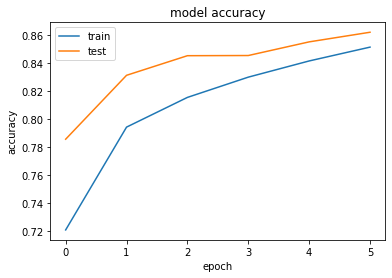

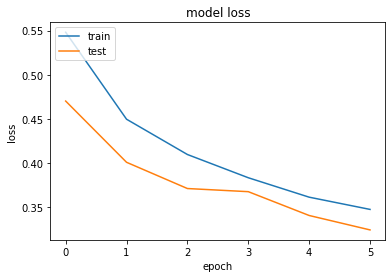

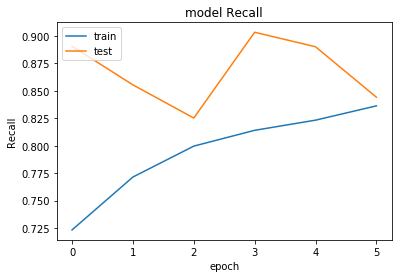

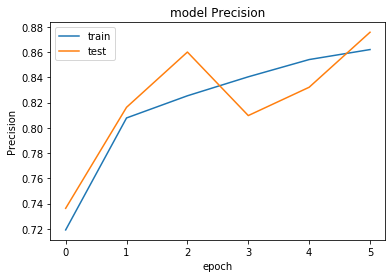

In [60]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_2'])
plt.plot(history.history['val_precision_2'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [79]:
#bag of words

In [90]:
model = Sequential()

model.add(Dense(128,input_shape= (46000,), activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               5888128   
_________________________________________________________________
dense_27 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_21 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 34        
_________________________________________________________________
dropout_22 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 3         
Total params: 5,890,229
Trainable params: 5,890,229
Non-trainable params: 0
___________________________________________

In [91]:
history = model.fit(X_train_mybag, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 69s 2ms/step - loss: 0.5745 - acc: 0.7063 - recall_4: 0.4979 - precision_4: 0.8516 - val_loss: 0.4872 - val_acc: 0.8867 - val_recall_4: 0.8712 - val_precision_4: 0.8991
Epoch 2/6
32000/32000 [==============================] - 75s 2ms/step - loss: 0.4421 - acc: 0.9096 - recall_4: 0.9404 - precision_4: 0.8855 - val_loss: 0.4346 - val_acc: 0.8845 - val_recall_4: 0.8972 - val_precision_4: 0.8749
Epoch 3/6
32000/32000 [==============================] - 74s 2ms/step - loss: 0.3721 - acc: 0.9293 - recall_4: 0.9679 - precision_4: 0.8983 - val_loss: 0.4088 - val_acc: 0.8783 - val_recall_4: 0.8832 - val_precision_4: 0.8745
Epoch 4/6
32000/32000 [==============================] - 74s 2ms/step - loss: 0.3273 - acc: 0.9371 - recall_4: 0.9756 - precision_4: 0.9057 - val_loss: 0.3874 - val_acc: 0.8729 - val_recall_4: 0.9227 - val_precision_4: 0.8391
Epoch 5/6
32000/32000 [========================

In [92]:
pr = model.predict(X_test_mybag)

In [95]:
cnf_matrix = metrics.confusion_matrix(Y_test, pr.round())
cnf_matrix

array([[4403,  558],
       [ 678, 4361]], dtype=int64)

In [96]:
recall_score(Y_test, pr.round())

0.8654494939472117

In [97]:
mean_squared_error(Y_test, pr.round())

0.1236

In [98]:
precision_score(Y_test, pr.round())

0.8865623094124823

In [99]:
accuracy_score(Y_test, pr.round())

0.8764

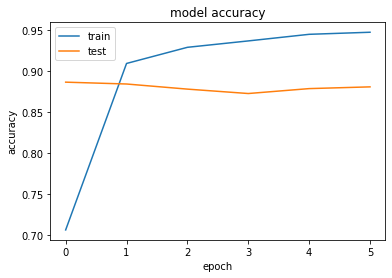

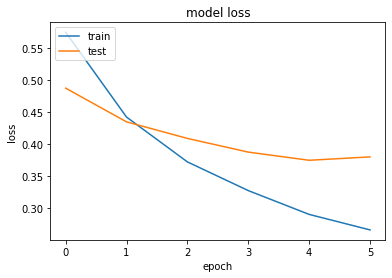

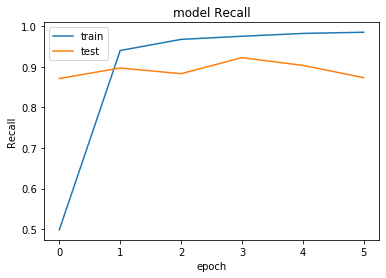

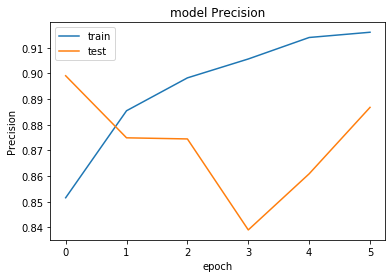

In [100]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_4'])
plt.plot(history.history['val_recall_4'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_4'])
plt.plot(history.history['val_precision_4'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [101]:
#tfidf


In [104]:
model = Sequential()

model.add(Dense(128,input_shape= (143682,), activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 128)               18391424  
_________________________________________________________________
dense_35 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 34        
_________________________________________________________________
dropout_26 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 3         
Total params: 18,393,525
Trainable params: 18,393,525
Non-trainable params: 0
_________________________________________

In [105]:
history = model.fit(X_train_tfidf, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 201s 6ms/step - loss: 0.5861 - acc: 0.6898 - recall_5: 0.6689 - precision_5: 0.6970 - val_loss: 0.4395 - val_acc: 0.9062 - val_recall_5: 0.9208 - val_precision_5: 0.8948
Epoch 2/6
32000/32000 [==============================] - 191s 6ms/step - loss: 0.3758 - acc: 0.8340 - recall_5: 0.7773 - precision_5: 0.8758 - val_loss: 0.3620 - val_acc: 0.9061 - val_recall_5: 0.9265 - val_precision_5: 0.8902
Epoch 3/6
32000/32000 [==============================] - 191s 6ms/step - loss: 0.2909 - acc: 0.8794 - recall_5: 0.7954 - precision_5: 0.9554 - val_loss: 0.3294 - val_acc: 0.9029 - val_recall_5: 0.9112 - val_precision_5: 0.8962
Epoch 4/6
32000/32000 [==============================] - 188s 6ms/step - loss: 0.2478 - acc: 0.8886 - recall_5: 0.8003 - precision_5: 0.9713 - val_loss: 0.3125 - val_acc: 0.9025 - val_recall_5: 0.9013 - val_precision_5: 0.9035
Epoch 5/6
32000/32000 [====================

In [107]:
pr = model.predict(X_test_tfidf)

In [108]:
cnf_matrix = metrics.confusion_matrix(Y_test, pr.round())
cnf_matrix

array([[4559,  402],
       [ 604, 4435]], dtype=int64)

In [109]:
recall_score(Y_test, pr.round())

0.8801349474102005

In [110]:
mean_squared_error(Y_test, pr.round())

0.1006

In [111]:
precision_score(Y_test, pr.round())

0.9168906346909241

In [112]:
accuracy_score(Y_test, pr.round())

0.8994

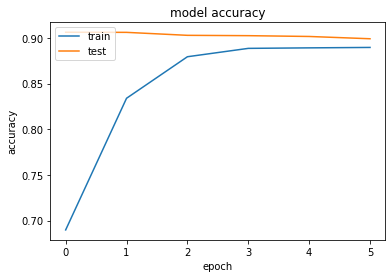

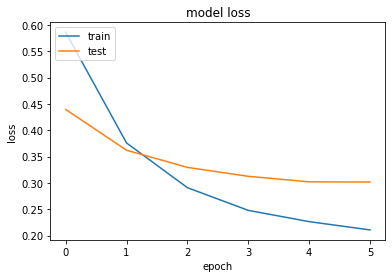

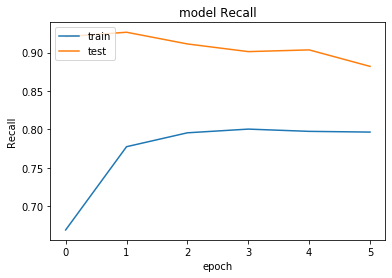

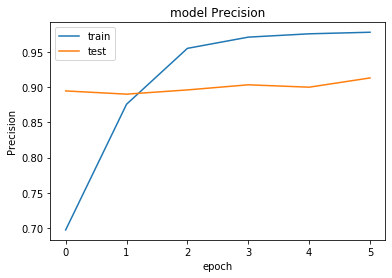

In [113]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_5'])
plt.plot(history.history['val_recall_5'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_5'])
plt.plot(history.history['val_precision_5'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [28]:
from keras.layers import Reshape

In [29]:
model = Sequential()
model.add(Reshape((71841,2),input_shape= (143682,)))
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(16,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(2,return_sequences = False))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

NameError: name 'LSTM' is not defined

In [7]:
most_common_wordstf = sorted(tfidf_vocab.items(), key=lambda x: x[1], reverse=True)[:]

NameError: name 'tfidf_vocab' is not defined

In [ ]:
print(X_test_mybag.shape[1])

In [ ]:
print(X_train_tfidf.shape[0])

In [ ]:
print(X_train_tfidf.shape[1])

In [ ]:
print(X_train_mybag[1])

In [ ]:
X_train_tfidf.shape[1]

In [ ]:
X_train_tfidf_3d=X_train_tfidf.toarray()

In [8]:
print(X_train_tfidf_3d.shape)

NameError: name 'X_train_tfidf_3d' is not defined

In [ ]:
from numpy import  newaxis
X_train_tfidf_3d=X_train_tfidf_3d[:,:,newaxis]

In [ ]:
print(X_train_tfidf_3d.shape)

In [ ]:
X_test_tfidf_3d=X_test_tfidf.toarray()

In [ ]:
print(X_test_tfidf_3d.shape)

In [ ]:
from numpy import  newaxis
X_test_tfidf_3d=X_test_tfidf_3d[:,:,newaxis]

In [9]:
print(X_test_tfidf_3d.shape)

NameError: name 'X_test_tfidf_3d' is not defined

In [ ]:
X_train_mybag_3d=X_train_mybag.toarray()

In [ ]:
print(X_train_mybag_3d.shape)

In [ ]:

X_train_mybag_3d=X_train_mybag_3d[:,:,newaxis]

In [ ]:
print(X_train_mybag_3d.shape)

In [46]:
X_test_mybag_3d=X_test_mybag.toarray()

In [47]:
print(X_test_mybag_3d.shape)

(10000, 46000)


In [48]:

X_test_mybag_3d=X_test_mybag_3d[:,:,newaxis]

In [49]:
print(X_test_mybag_3d.shape)

(10000, 46000, 1)


In [27]:
most_common_wordstf = sorted(tfidf_vocab.items(), key=lambda x: x[1], reverse=True)[:]

In [33]:
print(X_test_mybag.shape[1])

46000


In [34]:
print(X_train_tfidf.shape[0])

40000


In [35]:
print(X_train_tfidf.shape[1])

143682


In [36]:
print(X_train_mybag[1])

  (0, 0)	5.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 6)	5.0
  (0, 7)	1.0
  (0, 9)	1.0
  (0, 13)	1.0
  (0, 14)	4.0
  (0, 27)	2.0
  (0, 31)	3.0
  (0, 33)	1.0
  (0, 40)	1.0
  (0, 41)	1.0
  (0, 42)	1.0
  (0, 50)	1.0
  (0, 59)	1.0
  (0, 63)	2.0
  (0, 68)	1.0
  (0, 71)	1.0
  (0, 73)	1.0
  (0, 85)	3.0
  (0, 95)	1.0
  (0, 98)	1.0
  (0, 101)	1.0
  (0, 111)	1.0
  :	:
  (0, 1930)	1.0
  (0, 2091)	1.0
  (0, 2126)	1.0
  (0, 2148)	1.0
  (0, 2303)	1.0
  (0, 2989)	1.0
  (0, 3012)	1.0
  (0, 3435)	1.0
  (0, 3656)	2.0
  (0, 3780)	1.0
  (0, 3975)	1.0
  (0, 4348)	1.0
  (0, 5648)	1.0
  (0, 5940)	1.0
  (0, 6877)	1.0
  (0, 7441)	1.0
  (0, 10087)	1.0
  (0, 10969)	1.0
  (0, 11412)	1.0
  (0, 11983)	1.0
  (0, 12148)	5.0
  (0, 12343)	2.0
  (0, 14850)	2.0
  (0, 16506)	1.0
  (0, 17068)	1.0


In [ ]:
X_train_tfidf.shape[1]

In [ ]:
X_train_tfidf_3d=X_train_tfidf.toarray()

In [ ]:
print(X_train_tfidf_3d.shape)

In [ ]:
from numpy import  newaxis
X_train_tfidf_3d=X_train_tfidf_3d[:,:,newaxis]

In [ ]:
print(X_train_tfidf_3d.shape)

In [ ]:
X_test_tfidf_3d=X_test_tfidf.toarray()

In [ ]:
print(X_test_tfidf_3d.shape)

In [ ]:
from numpy import  newaxis
X_test_tfidf_3d=X_test_tfidf_3d[:,:,newaxis]

In [ ]:
print(X_test_tfidf_3d.shape)

In [ ]:
X_train_mybag_3d=X_train_mybag.toarray()

In [ ]:
print(X_train_mybag_3d.shape)

In [ ]:

X_train_mybag_3d=X_train_mybag_3d[:,:,newaxis]

In [ ]:
print(X_train_mybag_3d.shape)

In [46]:
X_test_mybag_3d=X_test_mybag.toarray()

In [47]:
print(X_test_mybag_3d.shape)

(10000, 46000)


In [48]:

X_test_mybag_3d=X_test_mybag_3d[:,:,newaxis]

In [49]:
print(X_test_mybag_3d.shape)

(10000, 46000, 1)


In [27]:
most_common_wordstf = sorted(tfidf_vocab.items(), key=lambda x: x[1], reverse=True)[:]

In [33]:
print(X_test_mybag.shape[1])

46000


In [34]:
print(X_train_tfidf.shape[0])

40000


In [35]:
print(X_train_tfidf.shape[1])

143682


In [36]:
print(X_train_mybag[1])

  (0, 0)	5.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 6)	5.0
  (0, 7)	1.0
  (0, 9)	1.0
  (0, 13)	1.0
  (0, 14)	4.0
  (0, 27)	2.0
  (0, 31)	3.0
  (0, 33)	1.0
  (0, 40)	1.0
  (0, 41)	1.0
  (0, 42)	1.0
  (0, 50)	1.0
  (0, 59)	1.0
  (0, 63)	2.0
  (0, 68)	1.0
  (0, 71)	1.0
  (0, 73)	1.0
  (0, 85)	3.0
  (0, 95)	1.0
  (0, 98)	1.0
  (0, 101)	1.0
  (0, 111)	1.0
  :	:
  (0, 1930)	1.0
  (0, 2091)	1.0
  (0, 2126)	1.0
  (0, 2148)	1.0
  (0, 2303)	1.0
  (0, 2989)	1.0
  (0, 3012)	1.0
  (0, 3435)	1.0
  (0, 3656)	2.0
  (0, 3780)	1.0
  (0, 3975)	1.0
  (0, 4348)	1.0
  (0, 5648)	1.0
  (0, 5940)	1.0
  (0, 6877)	1.0
  (0, 7441)	1.0
  (0, 10087)	1.0
  (0, 10969)	1.0
  (0, 11412)	1.0
  (0, 11983)	1.0
  (0, 12148)	5.0
  (0, 12343)	2.0
  (0, 14850)	2.0
  (0, 16506)	1.0
  (0, 17068)	1.0


In [ ]:
X_train_tfidf.shape[1]

In [ ]:
X_train_tfidf_3d=X_train_tfidf.toarray()

In [ ]:
print(X_train_tfidf_3d.shape)

In [ ]:
from numpy import  newaxis
X_train_tfidf_3d=X_train_tfidf_3d[:,:,newaxis]

In [ ]:
print(X_train_tfidf_3d.shape)

In [ ]:
X_test_tfidf_3d=X_test_tfidf.toarray()

In [ ]:
print(X_test_tfidf_3d.shape)

In [ ]:
from numpy import  newaxis
X_test_tfidf_3d=X_test_tfidf_3d[:,:,newaxis]

In [ ]:
print(X_test_tfidf_3d.shape)

In [ ]:
X_train_mybag_3d=X_train_mybag.toarray()

In [ ]:
print(X_train_mybag_3d.shape)

In [ ]:

X_train_mybag_3d=X_train_mybag_3d[:,:,newaxis]

In [ ]:
print(X_train_mybag_3d.shape)

In [46]:
X_test_mybag_3d=X_test_mybag.toarray()

In [47]:
print(X_test_mybag_3d.shape)

(10000, 46000)


In [48]:

X_test_mybag_3d=X_test_mybag_3d[:,:,newaxis]

In [49]:
print(X_test_mybag_3d.shape)

(10000, 46000, 1)
